In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import json
import pickle
import cv2
import re
import collections
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download adityajn105/flickr30k

100% 8.14G/8.16G [01:09<00:00, 178MB/s]
100% 8.16G/8.16G [01:09<00:00, 126MB/s]


In [ ]:
! unzip flickr30k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/flickr30k_images/535529555.jpg  
  inflating: Images/flickr30k_images/5356236664.jpg  
  inflating: Images/flickr30k_images/5356318668.jpg  
  inflating: Images/flickr30k_images/535830521.jpg  
  inflating: Images/flickr30k_images/5359437945.jpg  
  inflating: Images/flickr30k_images/5361355399.jpg  
  inflating: Images/flickr30k_images/53614287.jpg  
  inflating: Images/flickr30k_images/536147209.jpg  
  inflating: Images/flickr30k_images/5361551308.jpg  
  inflating: Images/flickr30k_images/536156200.jpg  
  inflating: Images/flickr30k_images/5362687336.jpg  
  inflating: Images/flickr30k_images/5363528971.jpg  
  inflating: Images/flickr30k_images/5363903246.jpg  
  inflating: Images/flickr30k_images/5364849864.jpg  
  inflating: Images/flickr30k_images/536495604.jpg  
  inflating: Images/flickr30k_images/5365075444.jpg  
  inflating: Images/flickr30k_images/536533294.jpg  
  inflating: Images/flickr30k_images/53

#Step 1: Data Collection

In [ ]:
# Read text Caption
def readTextFile(path):
  with open(path) as f:
    captions = f.read()
  return captions

In [ ]:
captions = readTextFile('captions.txt')
captions = captions.split('\n')[:-1]

##Dictonary to map each Image with the list of captions

In [ ]:
descriptions = {}
for x in captions:
  first,second = x.split(sep='\\t',maxsplit=-1)
  image_name = first.split('.')[0]

  # If the Image name is already exist or not
  if descriptions.get(image_name) is None:
    descriptions[image_name] = []
  descriptions[image_name].append(second)

In [ ]:
descriptions['1000092795']

[' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 ' Two young , White males are outside near many bushes .',
 ' Two men in green shirts are standing in a yard .',
 ' A man in a blue shirt standing in a garden .',
 ' Two friends enjoy time spent together .']

#Step 2: Understanding the Data

In [ ]:
IMG_PATH = "Flick8k_data/Images"


# Step 3: Data Cleaning

In [ ]:
def clean_text(sentence):
  sentence = sentence.lower()
  sentence = re.sub("[^a-z]"," ",sentence)
  sentence = sentence.split()

  sentence = [s for s in sentence if len(s)>1]
  sentence = " ".join(sentence)
  return sentence

## Clean all Captions

In [ ]:
for key,cap_list in descriptions.items():
  for i in range(len(cap_list)):
    cap_list[i] = clean_text(cap_list[i])

## Write the data to text file

In [ ]:
with open("descriptions.txt","w") as f:
  f.write(str(descriptions))

# Create Vocabulary

In [ ]:
descriptions = None
with open("descriptions.txt","r") as f:
  descriptions = f.read()

json_acceptable_string= descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [ ]:
vocab = set()
for key in descriptions.keys():
   [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size:%d"%len(vocab))

Vocab Size:18054


## Total no of words across all the sentence

In [ ]:
total_word = []
for key in descriptions.keys():
  [total_word.append(i) for des in descriptions[key] for i in des.split()]

print("Total words %d"%len(total_word))

Total words 1679075


## Filter words from the vocab according to certain threshold frequency

In [ ]:
counter = collections.Counter(total_word)
freq_cnt = dict(counter)

## sort the dictionary according to the fre count

In [ ]:
sorted_freq_count = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#Filter
threshold = 10
sorted_freq_count = [x for x in sorted_freq_count if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_count]
len(total_words)

5118

In [ ]:
len(descriptions)

31783

# Step 4: Loading the training set

In [ ]:
train = [key for key in descriptions.keys()]

In [ ]:
len(train)

31783

## Prepare descriptions for the training data
### Tweak - add startseq and endseq token to our training data

In [ ]:
train_descriptions= {}
for img_id in train:
  train_descriptions[img_id] = []
  for cap in descriptions[img_id]:
    cap_to_append = "startseq " + cap + " endseq"
    train_descriptions[img_id].append(cap_to_append)

In [ ]:
train_descriptions['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [ ]:
len(train_descriptions)

31783

# Step 5: Image Feature Extraction

## Data Preprocessing - Images

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

In [ ]:
# Get the InceptionV3 model trained on imagenet data
model = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

96124928/96112376 [==============================] - 1s 0us/step


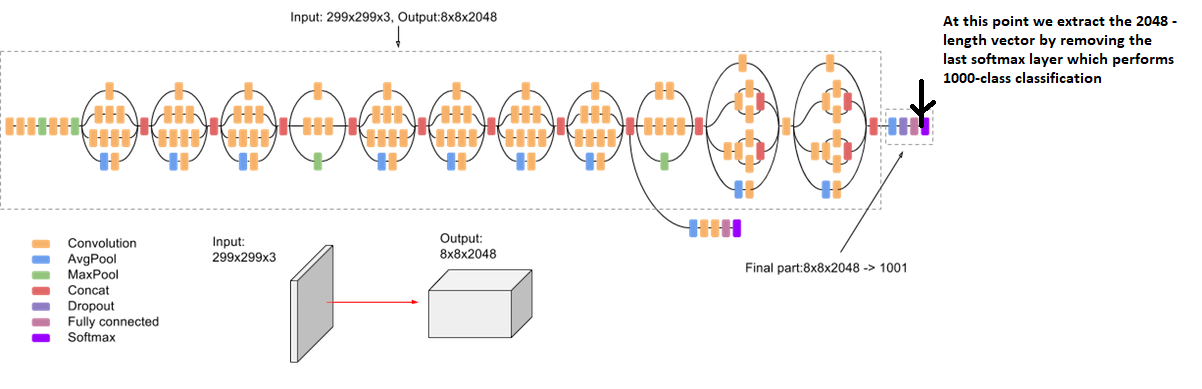

In [ ]:
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
def preprocess_img(img):
  # Convert all the images to size 299x299 as expected by the
  # inception v3 model
  img = image.load_img(image_path, target_size=(299, 299))
  # Convert PIL image to numpy array of 3-dimensions
  x = image.img_to_array(img)
  # Add one more dimension
  x = np.expand_dims(x, axis=0)
  # preprocess images using preprocess_input() from inception module
  x = preprocess_input(x)
  return x


In [ ]:
def encode_img(img):
  img = preprocess_img(img)
  feature_vector = model_new.predict(img)
  # reshape from (1, 2048) to (2048, )
  feature_vector = feature_vector.reshape((-1,))
  print(feature_vector.shape)
  return feature_vector

In [ ]:
image_path = "Images"+"/"+"1000092795"+".jpg"

encode_img(image_path)

(2048,)


array([0.18249542, 0.16290542, 0.52269596, ..., 0.6769264 , 0.3285834 ,
       0.08636545], dtype=float32)

In [ ]:
len(train)

31783

### Feature vector extracted from InceptionV3 Image

In [ ]:
#start = time()
encoding_train = {}
#img_id = Feature vector extracted from InceptionV3 Image

for ix,img_id in enumerate(train):
  image_path = "Images"+"/"+img_id+".jpg"

  encoding_train[img_id] = encode_img(image_path)
  if ix%100 == 0:
    print("Encoding in progress time step %d"%ix)

#end_t = time()
#print("Total Time taken:",end_t-start)

Streaming output truncated to the last 5000 lines.
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
Encoding in progress time step 26900
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)


In [ ]:
with open("encoded_train_features.pkl","wb") as f:
  pickle.dump(encoding_train,f)

In [ ]:
from google.colab import files
files.download("encoded_train_features.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 6: Data Preprocessing - Captions

In [ ]:
len(total_words)

5118

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
  word_to_idx[word] = i+1
  idx_to_word[i+1] = word

In [ ]:
len(word_to_idx)

5118

## Two Special Words

In [ ]:
idx_to_word[5119] = 'startseq'
word_to_idx['startseq'] = 5119
idx_to_word[5120] = 'endseq'
word_to_idx['endseq'] = 5120
vocab_size = len(word_to_idx) + 1

In [ ]:
with open("word_to_idx.pkl","wb") as f:
  pickle.dump(word_to_idx,f)
with open("idx_to_word.pkl","wb") as f:
  pickle.dump(idx_to_word,f)

## Maxlen caption 

In [ ]:
max_len = 0
for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    max_len = max(max_len,len(cap.split()))

print(max_len)

74


# IMPORTANT STEP :
## Setting up as a supervised Learning Problem



This is one of the most important steps in this case study. Here we will understand how to prepare the data in a manner which will be convenient to be given as input to the deep learning model.
Hereafter, I will try to explain the remaining steps by taking a sample example as follows:
Consider we have 3 images and their 3 corresponding captions as follows:

<p align="center">
  <img src="https://miro.medium.com/max/524/1*tVETPw5HjXoNM9Ne5DSZWA.jpeg" alt="Sublime's custom image"/>
</p>
<p align="center">
(Train image 1) Caption -> The black cat sat on grass
</p>
<p align="center">
  <img src="https://miro.medium.com/max/518/1*2fTSz1aB0JimPSBH9vsB5Q.jpeg" alt="Sublime's custom image"/>
</p>
<p align="center">
(Train image 2) Caption -> The white cat is walking on road
</p>
<p align="center">
  <img src="https://miro.medium.com/max/524/1*hUsFhuZJNXaLqzQJsCHGKg.jpeg" alt="Sublime's custom image"/>
</p>
<p align="center">
(Test image) Caption -> The black cat is walking on grass
</p>


Now, let’s say we use the first two images and their captions to train the model and the third image to test our model.
Now the questions that will be answered are: how do we frame this as a supervised learning problem?, what does the data matrix look like? how many data points do we have?, etc.
First we need to convert both the images to their corresponding 2048 length feature vector as discussed above. Let “Image_1” and “Image_2” be the feature vectors of the first two images respectively
Secondly, let’s build the vocabulary for the first two (train) captions by adding the two tokens “startseq” and “endseq” in both of them: (Assume we have already performed the basic cleaning steps)

Caption_1 -> “startseq the black cat sat on grass endseq”

Caption_2 -> “startseq the white cat is walking on road endseq”

vocab = {black, cat, endseq, grass, is, on, road, sat, startseq, the, walking, white}

Let’s give an index to each word in the vocabulary:
black -1, cat -2, endseq -3, grass -4, is -5, on -6, road -7, sat -8, startseq -9, the -10, walking -11, white -12

Now let’s try to frame it as a **supervised learning** problem where we have a set of data points D = {Xi, Yi}, where Xi is the feature vector of data point ‘i’ and Yi is the corresponding target variable.
Let’s take the first image vector **Image_1** and its corresponding caption **“startseq the black cat sat on grass endseq”**. Recall that, Image vector is the input and the caption is what we need to predict. But the way we predict the caption is as follows:
For the first time, we provide the image vector and the first word as input and try to predict the second word, i.e.:

Input = Image_1 + ‘startseq’; Output = ‘the’
Then we provide image vector and the first two words as input and try to predict the third word, i.e.:
Input = Image_1 + ‘startseq the’; Output = ‘cat’
And so on…
Thus, we can summarize the data matrix for one image and its corresponding caption as follows:

</p>
<p align="center">
  <img src="https://miro.medium.com/max/1114/1*0ixJXDqGxFYR6XZQc5Bh5w.jpeg" alt="Sublime's custom image"/>
</p>
<p align="center">
Data points corresponding to one image and its caption
</p>
It must be noted that, one image+caption is not a single data point but are multiple data points depending on the length of the caption.
Similarly if we consider both the images and their captions, our data matrix will then look as follows:

</p>
<p align="center">
  <img src="https://miro.medium.com/max/1400/1*ME49hZnlJDtkA4cWtZjKNg.jpeg" alt="Sublime's custom image"/>
</p>
<p align="center">
Data Matrix for both the images and captions
</p>

We must now understand that in every data point, it’s not just the image which goes as input to the system, but also, a partial caption which helps to **predict the next word in the sequence.**
Since we are **processing sequences**, we will employ a **Recurrent Neural Network** to read these partial captions (more on this later).
However, we have already discussed that we are not going to pass the actual English text of the caption, rather we are going to pass the sequence of indices where each index represents a unique word.
Since we have already created an index for each word, let’s now replace the words with their indices and understand how the data matrix will look like:

</p>
<p align="center">
  <img src="https://miro.medium.com/max/1032/1*6G1eDpwq11eRY4rhD0yXPg.jpeg" alt="Sublime's custom image"/>
</p>
<p align="center">
Data matrix after replacing the words by their indices
</p>


Since we would be doing batch processing (explained later), we need to make sure that each sequence is of equal length. Hence we need to append 0’s (zero padding) at the end of each sequence. But how many zeros should we append in each sequence?
Well, this is the reason we had calculated the maximum length of a caption, which is 34 (if you remember). So we will append those many number of zeros which will lead to every sequence having a length of 74.



# Step 7: Data preparation using generator function

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(train_descriptions, encoded_photos, word_to_idx, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while True:
        for key, cap_list in train_descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = encoded_photos[key]
            for desc in cap_list:
                # encode the sequence
                seq = [word_to_idx[word] for word in desc.split(' ') if word in word_to_idx]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair 
                    # in_seq = xi, out_seq = yi
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

# Step 8: Word Embeddings

In [ ]:
! kaggle datasets download incorpes/glove6b200d

 97% 250M/259M [00:03<00:00, 63.6MB/s]
100% 259M/259M [00:03<00:00, 72.4MB/s]


In [ ]:
! unzip glove6b200d.zip

Archive:  glove6b200d.zip
  inflating: glove.6B.200d.txt       


In [ ]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open('glove.6B.200d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

##  we create an embedding matrix which will be loaded into the model before training.

In [ ]:
def get_embedding_matrix():
  emb_dim = 200
  matrix = np.zeros((vocab_size,emb_dim))

  for word,idx in word_to_idx.items():
    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:
      matrix[idx] = embedding_vector
  return matrix

In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(5121, 200)

# Step 9: Model Architecture

The input consists of two parts, an image vector and a partial caption, we cannot use the Sequential API provided by the Keras library. For this reason, we use the Functional API which allows us to create Merge Models.

First, let’s look at the brief architecture which contains the high level sub-modules:
</p>
<p align="center">
  <img width="300" height="100" src="https://miro.medium.com/max/1400/1*rfYN2EELhLvp2Van3Jo-Yw.jpeg",>
</p>
<p align="center">
High Level Architecture
</p>

In [ ]:
# image feature extractor model
input_img_features = Input(shape=(2048,))
fe1 = Dropout(0.5)(input_img_features)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs_captions = Input(shape=(max_len,))
se1 = Embedding(vocab_size, 200, mask_zero=True)(inputs_captions)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[input_img_features, inputs_captions], outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 200)      1024200     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

## Important Thing Embedding layer

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

## Compile the model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam')

# Step 10: Training of Model

In [ ]:
epochs = 39
batch_size = 3
steps = len(train_descriptions)//batch_size

def train():
  for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose = 1)
    model.save("model_weights/model_"+str(i)+".h5")


In [ ]:
0train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


 4257/10594 [===========>..................] - ETA: 31:04 - loss: 3.4060